<a href="https://colab.research.google.com/github/lasmit17/SpotifyProject/blob/master/03_shapley_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# import packages
from google.colab import files
import io
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [14]:
# read in data
uploaded = files.upload()



KeyboardInterrupt: ignored

In [15]:
# Feature-Data as dataframes
luke_df_2016 = pd.read_csv(io.BytesIO(uploaded['Luke_2016_Top_Songs.csv']))
luke_df_2017 = pd.read_csv(io.BytesIO(uploaded['Luke_2017_Top_Songs.csv']))
luke_df_2018 = pd.read_csv(io.BytesIO(uploaded['Luke_2018_Top_Songs.csv']))
luke_df_2019 = pd.read_csv(io.BytesIO(uploaded['Luke_2019_Top_Songs.csv']))
luke_df_2020 = pd.read_csv(io.BytesIO(uploaded['Luke_2020_Top_Songs.csv']))

jp_df_2017 = pd.read_csv(io.BytesIO(uploaded['jp_2017_Top_Songs.csv']))
jp_df_2018 = pd.read_csv(io.BytesIO(uploaded['jp_2018_Top_Songs.csv']))
jp_df_2019 = pd.read_csv(io.BytesIO(uploaded['jp_2019_Top_Songs.csv']))
jp_df_2020 = pd.read_csv(io.BytesIO(uploaded['jp_2020_Top_Songs.csv']))

fabian_df_2017 = pd.read_csv(io.BytesIO(uploaded['FP_2017_Top_Songs.csv']))
fabian_df_2018 = pd.read_csv(io.BytesIO(uploaded['FP_2018_Top_Songs.csv']))
fabian_df_2019 = pd.read_csv(io.BytesIO(uploaded['fp_2019_Top_Songs.csv']))
fabian_df_2020 = pd.read_csv(io.BytesIO(uploaded['FP_2020_Top_Songs.csv']))

In [16]:
#Creating a function to add a new variable to the dataframes, the song release year
def get_years(df):
    years = []
    for date in df['release_date'].values:
        if '-' in date:
            years.append(date.split('-')[0])
        else:
            years.append(date)
    df['release_year'] = years
    return df


#Adding release year to each dataframe for each individual
luke_df_2016 = get_years(luke_df_2016)
luke_df_2017 = get_years(luke_df_2017)
luke_df_2018 = get_years(luke_df_2018)
luke_df_2019 = get_years(luke_df_2019)
luke_df_2020 = get_years(luke_df_2020)

jp_df_2017 = get_years(jp_df_2017)
jp_df_2018 = get_years(jp_df_2018)
jp_df_2019 = get_years(jp_df_2019)
jp_df_2020 = get_years(jp_df_2020)

fabian_df_2018 = get_years(fabian_df_2018)
fabian_df_2019 = get_years(fabian_df_2019)
fabian_df_2020 = get_years(fabian_df_2020)
fabian_df_2017 = get_years(fabian_df_2017)

#combining each person's data
luke_df_concat = pd.concat([luke_df_2016, luke_df_2017, luke_df_2018, luke_df_2019, luke_df_2020], ignore_index=True, axis=0)
luke_df_concat['users_name'] = "Luke"

jp_df_concat = pd.concat([jp_df_2017, jp_df_2018, jp_df_2019, jp_df_2020], ignore_index=True, axis=0)
jp_df_concat['users_name'] = "JP"

fabian_df_concat = pd.concat([fabian_df_2017, fabian_df_2018, fabian_df_2019, fabian_df_2020], ignore_index=True, axis=0)
fabian_df_concat['users_name'] = "Fabian"

#Combining every data frame together into one
all_df = pd.concat([luke_df_concat, jp_df_concat, fabian_df_concat], ignore_index=True, axis=0)
all_df["release_year"] = pd.to_numeric(all_df["release_year"])


In [17]:
# remove repeats on individual playlists
def remove_repeats(df):
    rows_old = range(len(df['name']))
    rows_new = []
    skips = []
    for i in range(len(df['name'])):
        for j in range(i+1, len(df['name'])):
            if (df['name'][i] == df['name'][j]) and (df['artist'][i] == df['artist'][j]):
                skips.append(j)
    for row in rows_old:
        if not row in skips:
            rows_new.append(row)
    df = df.iloc[rows_new,:].reset_index(drop=True)
    return df
remove_repeats(all_df)


# Create function to do linear transformation on variable to change value to [0,1]
def convert_scale(df, col):
    df[col + '_old'] = df[col]
    new_max = 1
    new_min = 0
    new_range = new_max-new_min
    max_val = df[col].max()
    min_val=df[col].min()
    val_range = max_val - min_val
    df[col]=df[col].apply(lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return

#Setting the numerical spotify features
numeric_spotify_features = ['energy',
    'valence',
    'danceability',
    'liveness',
    'speechiness',
    'instrumentalness',
    'acousticness',
    'loudness',
    'length',
    'popularity',
    'tempo',
    'release_year']


for col in numeric_spotify_features:
    convert_scale(all_df, col)

#Now we need to address the categorical variables. First, we will utilize One Hot Encoder
ohe = OneHotEncoder()
ohe_results = ohe.fit_transform(all_df[['time_signature', 'mode', 'key']])
onehot_df = pd.DataFrame(ohe_results.toarray(), columns=['time_signature_1', 'time_signature_2',
                                                     'time_signature_3', 'time_signature_4',
                                                     'mode_1', 'mode_2',
                                                     'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
                                                     'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'key_12'])
all_df = pd.concat([all_df, onehot_df], axis=1)

#Finally, we combine all of our features used for prediction into one list
all_spotify_features = ['energy',
    'valence',
    'danceability',
    'liveness',
    'speechiness',
    'instrumentalness',
    'acousticness',
    'loudness',
    'length',
    'popularity',
    'tempo',
    'release_year',
    'time_signature_1',
    'time_signature_2',
    'time_signature_3',
    'time_signature_4',
    'mode_1',
    'mode_2',
    'key_1',
    'key_2',
    'key_3',
    'key_4',
    'key_5',
    'key_6',
    'key_7',
    'key_8',
    'key_9',
    'key_10',
    'key_11',
    'key_12']

In [18]:
# Train Model
#Now, we can finally set our X and y values. X will be all the Spotify features provided above and y will be each individual's name
X = all_df[all_spotify_features]
y = all_df['users_name']

#Here we split our data up into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)


#Setting up a pipeline that scales and then utilizes multinomial logistic regression
pipe = Pipeline([('scaler', StandardScaler()),     # Step 1
                 ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs')) # Step 2
                 ])
#Fitting and predicting with our data
pipe.fit(X_train, y_train)
pred_logi = pipe.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, pred_logi))


#Preforming cross-validation
cv = KFold(n_splits=10, random_state=123, shuffle=True)
scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores

#More metrics
accuracy = accuracy_score(y_test, pred_logi)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, pred_logi))

Accuracy: 0.6338461538461538
Accuracy: 0.63
              precision    recall  f1-score   support

      Fabian       0.49      0.44      0.47        97
          JP       0.77      0.65      0.71        94
        Luke       0.64      0.76      0.70       134

    accuracy                           0.63       325
   macro avg       0.64      0.62      0.62       325
weighted avg       0.64      0.63      0.63       325



In [20]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

#Bringing in the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state = 123)

#Train the model using the training sets created earlier on
clf.fit(X_train,y_train)

clf_y_pred = clf.predict(X_test)

#Evaluating the base Random Forest Model
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, clf_y_pred))

clf_initial_score = cross_val_score(clf, X, y, cv=10)
clf_initial_score

# Our base RF model has an accuracy of about 69.5% 
# We did not put random state in second line.

Accuracy: 0.6707692307692308


array([0.66153846, 0.60769231, 0.69230769, 0.7       , 0.66923077,
       0.59230769, 0.74615385, 0.77692308, 0.60769231, 0.66153846])

In [21]:
#Checking to see which parameters are being utilized by Random Forest
clf.get_params()

n_estimators = [5,20,50,100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

clf_params = {
    'n_estimators'      : n_estimators,
    'max_features'      : max_features,
    'max_depth'         : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf'  : min_samples_leaf,
    'bootstrap'          : bootstrap
}

clf_random = RandomizedSearchCV(estimator = clf,param_distributions = clf_params,
               n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)

clf_random.fit(X_train, y_train)

#Now lets see what the best parameters are in this case
clf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

#Creating a RF model with the best parameters
clf_final = RandomForestClassifier(n_estimators = 50,
 min_samples_split = 10,
 min_samples_leaf = 3,
 max_features = 'auto',
 max_depth = 90,
 bootstrap = False,
 random_state = 123)

#Fitting the new model to the training data
clf_final.fit(X_train,y_train)
clf_pred_final = clf_final.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, clf_pred_final))

clf_final_score = cross_val_score(clf_final, X, y, cv=10)
clf_initial_score
clf_final_score

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: 0.6523076923076923


array([0.68461538, 0.61538462, 0.66923077, 0.7       , 0.68461538,
       0.63076923, 0.7       , 0.75384615, 0.66153846, 0.63846154])

In [22]:
#this is for f1
from sklearn.metrics import f1_score

#F1 score is always between 0 and 1
#Score of 0 is bad, score of 1 is good

#f1_logi = f1_score(y_test, pred_logi, average='macro')
#f1_xgb = f1_score(y_test, pred_xgb, average='macro')
print("F1 Logistic (base):",f1_logi)
print("F1 Logistic (xgb):","unfortunately, python says 'no module named xgboost' when i import xgboost")

ValueError: ignored

In [23]:
f1_rf_macro = f1_score(y_test, clf_y_pred, average='macro')
f1_rf_micro = f1_score(y_test, clf_y_pred, average='micro')
f1_rf_w = f1_score(y_test, clf_y_pred, average='weighted')


print("\nF1 RandomForest (base_macro):",f1_rf_macro)
print("F1 RandomForest (base_micro):",f1_rf_micro)
print("F1 RandomForest (base_weighted):",f1_rf_w)

print("\n  The difference between macro, micro, and weighted is this:")
print("  basically, since we have a 3x3 confusion matrix, we don't only have")
print("  ONE kind of false positive, true positive, etc...")
print("  the model can predict a true jp as being luke OR fabio, meaning our TN, TP, FN, FP")
print("  are not so straightforward")
print("\n  --macro, micro, and weighted are just different ways of combining the 3x3 matrix")
print("  to get a better picture of your f1 score")


f1_rf_tuned_macro = f1_score(y_test, clf_pred_final, average='macro')
f1_rf_tuned_micro = f1_score(y_test, clf_pred_final, average='micro')
f1_rf_tuned_w = f1_score(y_test, clf_pred_final, average='weighted')

print("\nF1 RandomForest (tuned_macro):",f1_rf_tuned_macro)
print("F1 RandomForest (tuned_micro):",f1_rf_tuned_micro)
print("F1 RandomForest (tuned_weighted):",f1_rf_tuned_w)



F1 RandomForest (base_macro): 0.6549503791358224
F1 RandomForest (base_micro): 0.6707692307692308
F1 RandomForest (base_weighted): 0.6629025192131044

  The difference between macro, micro, and weighted is this:
  basically, since we have a 3x3 confusion matrix, we don't only have
  ONE kind of false positive, true positive, etc...
  the model can predict a true jp as being luke OR fabio, meaning our TN, TP, FN, FP
  are not so straightforward

  --macro, micro, and weighted are just different ways of combining the 3x3 matrix
  to get a better picture of your f1 score

F1 RandomForest (tuned_macro): 0.6414832431250342
F1 RandomForest (tuned_micro): 0.6523076923076923
F1 RandomForest (tuned_weighted): 0.6485322062552832


In [25]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.3 MB/s 


In [26]:
# import shap
import shap

In [27]:
explainer = shap.TreeExplainer(clf_final, X_train)
shap_values = explainer(X_test, check_additivity = False)

print(f"Shap length: {len(shap_values)}\n")
print(f"Sample shap value:\n{shap_values[0]}")


Shap length: 325

Sample shap value:
.values =
array([[ 5.28384865e-02, -5.01896444e-02, -2.64884080e-03],
       [ 2.98980382e-02, -2.13794370e-02, -8.51860118e-03],
       [ 1.37630251e-02, -1.92500109e-02,  5.48698692e-03],
       [-5.67810455e-03, -9.44351526e-03,  1.51216199e-02],
       [ 4.57653731e-04, -1.64675101e-02,  1.60098569e-02],
       [-3.56481963e-02,  1.06456676e-01, -7.08084787e-02],
       [ 4.77149338e-02, -5.02609762e-02,  2.54604390e-03],
       [ 8.30678969e-02, -2.05374393e-02, -6.25304596e-02],
       [ 5.18896779e-03,  4.98954121e-02, -5.50843817e-02],
       [-1.34738713e-02,  4.43549260e-02, -3.08810562e-02],
       [ 2.93573331e-02,  2.44996861e-02, -5.38570188e-02],
       [ 4.44052455e-02,  1.71146346e-02, -6.15198817e-02],
       [-4.99999989e-05,  4.33333358e-05,  6.66666718e-06],
       [ 7.22978998e-04, -8.92721329e-04,  1.69742376e-04],
       [ 7.65158926e-04, -3.80613408e-04, -3.84545597e-04],
       [ 4.05013299e-05,  1.22685195e-05, -5.27698413

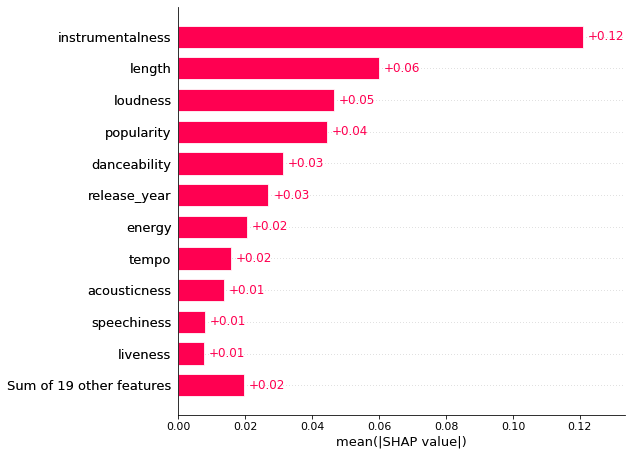

In [44]:
import matplotlib.pyplot as plt

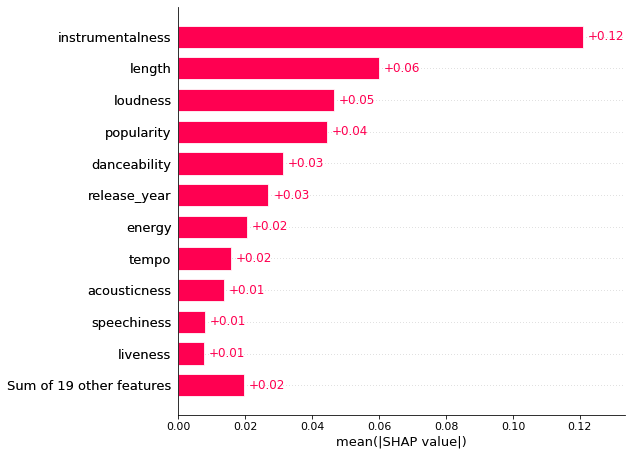

In [46]:
shap_all = shap.plots.bar(shap_values[:, :, 1], max_display=12, show=False)
plt.savefig('shap_all_avg', bbox_inches="tight", dpi = 144)

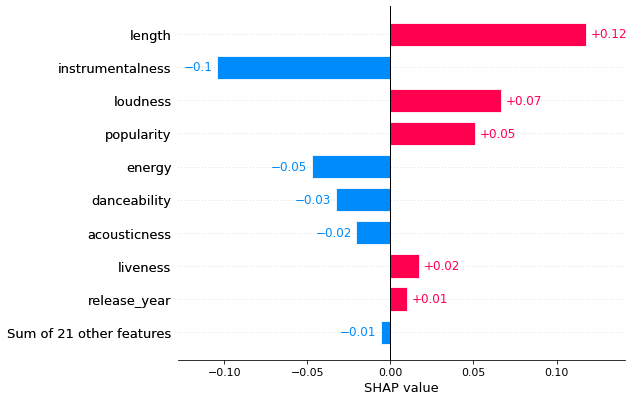

In [43]:
shap_local_12 = shap.plots.bar(shap_values[:, :, 1][200], max_display=10, show=False)
plt.savefig('shap_local_12', bbox_inches="tight", dpi = 144)

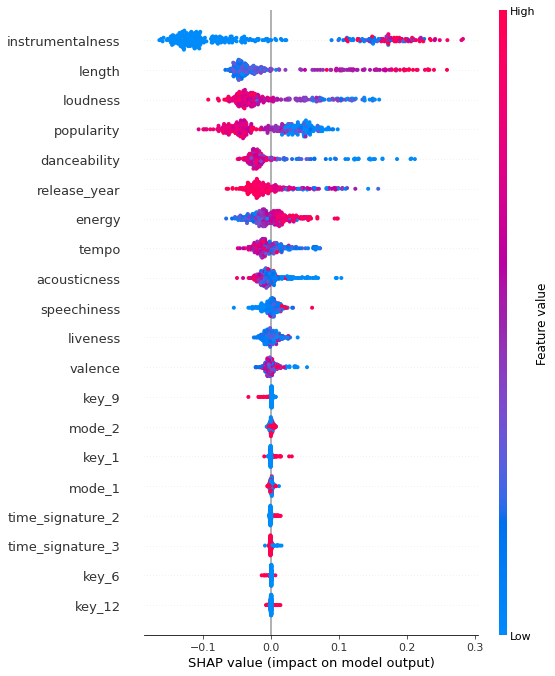

<Figure size 432x288 with 0 Axes>

In [42]:
shap.summary_plot(shap_values[:, :, 1], X_test)
plt.savefig('shap_summary_plot.png', bbox_inches="tight", dpi = 144)